<a href="https://colab.research.google.com/github/DanB1421/DATA602/blob/main/Brilliant_Problem_Set_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 3

## Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz

###Import data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir -p datashim
!cp /content/drive/Shareddrives/DS602-F22/Data/data602.py ./datashim
from datashim import data602

Mounted at /content/drive


In [ ]:
wdf = data602.read_weather()
cdf = data602.read_citations()

# Question 1 -- Statistical data visualization
In the first assignment, problem 3, you identified an ``interesting'' pattern in the weather or citations dataset.  Recall that discovered knowledge should be novel, useful, and non-trivial.  Develop a explanatory visualization to present the knowledge you discovered.  (You may choose a different pattern from the one you used in the first homework assignment if you wish.)

In [ ]:
wdf.head() # displayed first 5 values of the wdf data set

,date,wnd_speed,tmp_meas,precip,precip_intensity,cloudcover,tstorm,winter,mist,fog
0,2015-12-31 19:54:00-05:00,1.5,7.2,0.0,0,4.0,0,0,0,0
1,2015-12-31 20:54:00-05:00,3.1,6.1,0.0,0,4.0,0,0,0,0
2,2015-12-31 21:54:00-05:00,2.1,6.7,0.0,0,4.0,0,0,0,0
3,2015-12-31 22:54:00-05:00,2.6,6.1,0.0,0,4.0,0,0,0,0
4,2015-12-31 23:54:00-05:00,2.1,5.6,0.0,0,4.0,0,0,0,0


Text(0.5, 1.0, 'Average Monthly Temperature Variation over Time')

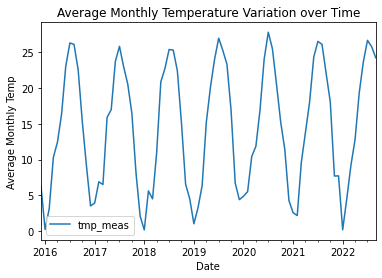

In [ ]:
wdf_agg = wdf.groupby(pd.PeriodIndex(wdf['date'], freq="M")).mean() # created new dataframe grouping by monthly average temperature, method found here: https://stackoverflow.com/questions/65471540/get-monthly-average-in-pandas
wdf_agg.reset_index(level=0, inplace=True) # reset index to create date as a column
wdf_agg.plot(x="date", y="tmp_meas") # plot time series of date and average monthly temperature
plt.xlabel("Date",  size = 10) # labeled plot "Date" on the x axis
plt.ylabel("Average Monthly Temp", size = 10) # labeled plot "Average Monthly Temp" on the y axis
plt.title("Average Monthly Temperature Variation over Time")

#Question 2 -- Data preparation

This problem uses the weather dataset from previous problem sets.  Prepare a dataset to predict the observed temperature from the following predictors:

* The non-temperature fields from the observation
* The temperature recorded in the prior observation

Beginning with the weather dataset:

a. Using imputation, replace missing values on temperature (`tmp_meas`) with reasonable non-missing values.  Then, add the temperature from the prior reading as a new feature.  That is, for each observation at time $t_k$, $k>0$, the new feature should have the value of the temperature reading at time $t_{k-1}$.  For the first observation ($k=0$), the value should be missing because the prior temperature is unknown.


In [ ]:
wdf_null_tmp = wdf[wdf['tmp_meas'].isnull()] # finds rows containing null tmp_meas values
wdf_null_tmp # displays null tmp_meas rows

,date,wnd_speed,tmp_meas,precip,precip_intensity,cloudcover,tstorm,winter,mist,fog
7767,2016-11-19 12:54:00-05:00,4.6,NaN,0.0,0,1.0,0,0,0,0
45611,2021-03-16 00:54:00-04:00,NaN,NaN,0.0,0,NaN,0,0,0,0


In [ ]:
from sklearn.impute import KNNImputer # imports KNNImputer from sklearn
imputer = KNNImputer(n_neighbors=2) # creates imputer using the 2 nearest neighbors
wdf['date'] = pd.to_numeric(pd.to_datetime(wdf['date'])) # converts the datetime column to numeric to prevent imputing error, method found here: https://stackoverflow.com/questions/41256626/pandas-typeerror-float-argument-must-be-a-string-or-a-number
wdf_imputed = pd.DataFrame(data=imputer.fit_transform(wdf), columns=wdf.columns) # imputes the dataframe using the created imputer
wdf['tmp_meas'] = wdf_imputed['tmp_meas'] # replaces the tmp_meas column with the imputed tmp_meas column
wdf['prior_tmp_meas'] = wdf['tmp_meas'].shift() # creates a column with the prior tmp_meas value displayed for each row
wdf.iloc[[7766, 7767, 7768, 45610, 45611, 45612]] # displays the previously null rows with their imputed values along with their nearest neighbors

,date,wnd_speed,tmp_meas,precip,precip_intensity,cloudcover,tstorm,winter,mist,fog,prior_tmp_meas
7766,1479574440000000000,2.1,21.1,0.0,0,1.0,0,0,0,0,18.3
7767,1479578040000000000,4.6,21.1,0.0,0,1.0,0,0,0,0,21.1
7768,1479581640000000000,4.1,21.1,0.0,0,2.0,0,0,0,0,21.1
45610,1615866840000000000,0.0,4.4,0.0,0,4.0,0,0,0,0,4.4
45611,1615870440000000000,NaN,4.4,0.0,0,NaN,0,0,0,0,4.4
45612,1615874040000000000,0.0,4.4,0.0,0,4.0,0,0,0,0,4.4


b. The observed temperature is the target variable.  Remove the observed temperature from the data frame, and save the values into a matrix $\mathbf{y}$

In [ ]:
y = wdf['tmp_meas'].to_numpy().reshape(-1,1) # converted tmp_meas series into a one column numpy array

c. Treat missing values in the dataframe so that the output dataset contains no missing values.  In the notebook, explain your approach to treat missing values.

In [ ]:
wdf.columns[wdf.isnull().any()] # displays columns containing null values in wdf

Index(['wnd_speed', 'precip', 'cloudcover', 'prior_tmp_meas'], dtype='object')

In [ ]:
wdf_imputed.columns[wdf_imputed.isnull().any()] # displays columns containing null values in the imputed wdf

Index([], dtype='object')

In [ ]:
wdf['wnd_speed'] = wdf_imputed['wnd_speed'] # replaces the wnd_speed column with the imputed wnd_speed column
wdf['precip'] = wdf_imputed['precip'] # replaces the precip column with the imputed precip column
wdf['cloudcover'] = wdf_imputed['cloudcover'] # replaces the cloudcover column with the imputed cloudcover column
wdf.columns[wdf.isnull().any()] # displays remaining columns containing null values in wdf (prior_tmp_meas will remain null due to the first entry not having a prior tmp value)

Index(['prior_tmp_meas'], dtype='object')

The other missing values in the dataframe were treated by replacing the columns in wdf containing missing values with the values from the previously derived wdf_imputed dataframe using two nearest neighbors. This was an intuitive method to do so because it was properly utilized to replace the missing values in the tmp_meas column, and thus was a reasonable method to repeat.

d. Remove the date field as well as the first observation (which has no prior temperature value) from the dataframe

In [ ]:
wdf_clean = wdf.drop(columns=['date']).dropna().reset_index(drop=True) # removes the date column, drops the first row (the only row containing a null value), and resets the index
wdf_clean.head() # displays the first 5 entries of wdf_clean

,wnd_speed,tmp_meas,precip,precip_intensity,cloudcover,tstorm,winter,mist,fog,prior_tmp_meas
0,3.1,6.1,0.0,0,4.0,0,0,0,0,7.2
1,2.1,6.7,0.0,0,4.0,0,0,0,0,6.1
2,2.6,6.1,0.0,0,4.0,0,0,0,0,6.7
3,2.1,5.6,0.0,0,4.0,0,0,0,0,6.1
4,2.1,5.0,0.0,0,4.0,0,0,0,0,5.6


e. Construct and apply a `ColumnTransformer` that inputs the dataset into a matrix that is suitable for machine learning.  This output matrix ($\mathbf{X}$) will have the following properties:

* All matrix elements are numeric and at approximately the same scale
* It does not include the target variable (observation temperature)
* There are no missing values

For each imputer and scaler that you use, provide your rationale.

In [ ]:
from sklearn.compose import ColumnTransformer # imports ColumnTransformer from sklearn
from sklearn.preprocessing import MinMaxScaler # imports MinMaxScaler from sklearn
from sklearn.pipeline import make_pipeline # imports make_pipeline from sklearn
useful_columns = wdf_clean.columns.drop(['tmp_meas']) # designates all columns from wdf_clean except tmp_meas (the target variable)
ct = ColumnTransformer(
   [
   ('useful_column_transform',
    make_pipeline(
        KNNImputer(n_neighbors=2),
        MinMaxScaler()),
    useful_columns)
   ]
) # creates a ColumnTransformer which uses a pipeline to impute missing values using their two nearest neighbors and scale values according to their minima and maxima

X = ct.fit_transform(wdf_clean) # performs the constructed column transformation on useful_columns in wdf_clean

For imputing, KNNImputer with two nearest neighbors was used because in a large dataset, the two nearest neighbors can be useful in approximating measurements in the same time frame, as there won't be large variation. For scaling, MinMaxScaler was used because it provides a standardized way to determine values that does not depend on other columns in the dataframe.

Show the first few rows of the resulting matrices $\mathbf{X}$ and $\mathbf{y}$.

In [ ]:
X[0:3] # displays the first few rows of X

array([[0.17222222, 0.        , 0.        , 0.8       , 0.        ,
        0.        , 0.        , 0.        , 0.432282  ],
       [0.11666667, 0.        , 0.        , 0.8       , 0.        ,
        0.        , 0.        , 0.        , 0.41187384],
       [0.14444444, 0.        , 0.        , 0.8       , 0.        ,
        0.        , 0.        , 0.        , 0.42300557]])

In [ ]:
y[0:3] # displays the first few rows of y

array([[7.2],
       [6.1],
       [6.7]])